coggers is my favorite song from interstellar, let's see what it looks like

In [1]:
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
import numpy as np
import librosa as libr

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
coggers, sample_rate = libr.load('data/hans_zimmer/sample.wav', sr=8000, mono=False)
# coggers, sample_rate = libr.load('data/hans_zimmer/coggers.wav', sr=8000, mono=False)

In [3]:
# split the data into two tracks for separate training

a = coggers[0]
b = coggers[1]
del coggers

In [4]:
def take_sample(start, end):
    a = a[start*sample_rate : end*sample_rate]
    b = b[start*sample_rate : end*sample_rate]

    sample = np.stack((a,b)).T

    wav.write('data/hans_zimmer/sample.wav', sample_rate, sample)

# take_sample(start=155, end=165)

In [5]:
# HYPERPARAMETERS
SEQ_LEN = 1 # this is in seconds
SEQ_LEN = int(SEQ_LEN * sample_rate)
print(SEQ_LEN)

HIDDEN_DIM = 2000
N_LAYERS = 2

OUT_DIM = 2

EPOCHS = 1
LR = 0.0001

8000


In [6]:
class LSTM(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_layers, out_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.lstm = nn.LSTM(in_dim, hidden_dim, n_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, out_dim)
    
    def forward(self, x):
        x, h = self.lstm(x.view(len(x),1,-1))
        x = self.fc1(x)
        return F.tanh(x)

In [7]:
model_a = LSTM(SEQ_LEN, HIDDEN_DIM, N_LAYERS, OUT_DIM).cuda()
model_b = LSTM(SEQ_LEN, HIDDEN_DIM, N_LAYERS, OUT_DIM).cuda()

In [8]:
def train(n='cp'):
    losses_a = []
    losses_b = []

    optimizer_a = optim.Adam(model_a.parameters(), lr=LR)
    optimizer_b = optim.Adam(model_b.parameters(), lr=LR)

    loss_fn_a = nn.MSELoss()
    loss_fn_b = nn.MSELoss()

    for epoch in range(EPOCHS):
        for i in tqdm(  range(  int((len(a)-SEQ_LEN)/OUT_DIM)  )  ):
            Xa = a[i*OUT_DIM : i*OUT_DIM + SEQ_LEN]
            Ya = a[i*OUT_DIM+SEQ_LEN : (i+1)*OUT_DIM + SEQ_LEN]

            Xa = torch.tensor(Xa).cuda().float()
            Ya = torch.tensor(Ya).cuda().float()

            Xa = Xa.view(-1, SEQ_LEN)

            out_a = model_a(Xa)
            loss_a = loss_fn_a(out_a, Ya)

            del Xa, Ya

            model_a.zero_grad()
            loss_a.backward()
            optimizer_a.step()
            losses_a.append(loss_a.item())

            
            Xb = b[i*OUT_DIM : i*OUT_DIM + SEQ_LEN]
            Yb = b[i*OUT_DIM+SEQ_LEN : (i+1)*OUT_DIM + SEQ_LEN]

            Xb = torch.tensor(Xb).cuda().float()
            Yb = torch.tensor(Yb).cuda().float()

            Xb = Xb.view(-1, SEQ_LEN)

            out_b = model_b(Xb)
            loss_b = loss_fn_b(out_b, Yb)

            del Xb, Yb

            model_b.zero_grad()
            loss_b.backward()
            optimizer_b.step()
            losses_b.append(loss_b)
            
            if i%1000==0:
                torch.save(model_a.state_dict(), f'models/hans_zimmer/checkpoints/{n}_a.pt')
                torch.save(model_b.state_dict(), f'models/hans_zimmer/checkpoints/{n}_b.pt')
    plt.plot(losses_a)
    plt.plot(losses_b)
    plt.show()

In [9]:
def load(n):
    model_a.load_state_dict(torch.load(f'models/hans_zimmer/{n}_a.pt'))
    model_b.load_state_dict(torch.load(f'models/hans_zimmer/{n}_b.pt'))
def save(n):
    torch.save(model_a.state_dict(), f'models/hans_zimmer/{n}_a.pt')
    torch.save(model_b.state_dict(), f'models/hans_zimmer/{n}_b.pt')

In [16]:
def predict(n):
    pred_a = np.array([])
    pred_b = np.array([])

    for i in tqdm(  range(  int((len(a)-SEQ_LEN)/OUT_DIM)  )  ):
        Xa = a[i*OUT_DIM : i*OUT_DIM + SEQ_LEN]
        Xb = b[i*OUT_DIM : i*OUT_DIM + SEQ_LEN]

        Xa = torch.tensor(Xa).cuda().float()
        Xb = torch.tensor(Xb).cuda().float()
        
        Xa = Xa.view(-1, SEQ_LEN)
        Xb = Xb.view(-1, SEQ_LEN)

        out_a = model_a(Xa).squeeze().cpu()
        out_b = model_b(Xb).squeeze().cpu()

        out_a = out_a.detach().numpy()
        out_b = out_b.detach().numpy()

        pred_a = np.concatenate((pred_a, out_a))
        pred_b = np.concatenate((pred_b, out_b))

    song = np.stack((pred_a, pred_b))
    wav.write(f'data/hans_zimmer/{n}.wav', sample_rate, song.T)

In [19]:
def generate(length, n):
    # im not creative so im just calling the generated sequences A and B
    A = a[:SEQ_LEN]
    B = b[:SEQ_LEN]

    for i in tqdm(range(int((length-SEQ_LEN)/OUT_DIM))):
        Xa = A[-SEQ_LEN:]
        Xb = B[-SEQ_LEN:]

        Xa = torch.tensor(Xa).cuda().float().view(-1, SEQ_LEN)
        Xb = torch.tensor(Xb).cuda().float().view(-1, SEQ_LEN)

        out_a = model_a(Xa).squeeze().cpu()
        out_b = model_a(Xb).squeeze().cpu()

        out_a = out_a.detach().numpy()
        out_b = out_b.detach().numpy()

        A = np.concatenate((A, out_a))
        B = np.concatenate((B, out_b))

    song = np.stack((A, B))

    wav.write(f'data/hans_zimmer/{n}.wav', sample_rate, song.T)

100%|██████████| 36000/36000 [1:00:34<00:00,  9.91it/s]


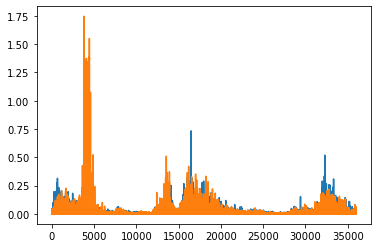

In [12]:
# train()
load('tanh')

In [17]:
predict('tanh')

100%|██████████| 36000/36000 [02:20<00:00, 256.51it/s]


In [20]:
generate(40000,'tanh')

100%|██████████| 16000/16000 [01:01<00:00, 259.90it/s]


doesn't exactly sound great but will do for now 